<a href="https://colab.research.google.com/github/YuehMintTai/RPython/blob/main/Class08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#三軍總醫院北投分院統計及實驗設計課程之八
## 2021/7/13
## ytai1123@gmail.com
### 使用方法:


1.   使用gmail帳號登入
2.   按"執行階段" -->"全部執行" 以執行全部內容, 若要個別執行可點選每格程式左方箭頭或按 Control + Enter 鍵執行。

In [77]:
##0-1
!git clone https://github.com/YuehMintTai/RPython.git

fatal: destination path 'RPython' already exists and is not an empty directory.


In [78]:
##0-2
!pip install rpy2

In [79]:
##0-3
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [80]:
##8-0-0
import tensorflow as tf
import torch
tf.__version__     ##2.5.0
torch.__version__   ##1.9.0+cu102

'1.9.0+cu102'

In [81]:
##8-0-1 區分所有的資料為testing, validating及training sets
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
import numpy as np

df=pd.read_csv('RPython/samples.csv')
df['sex']='男'
df.loc[df['性別']==2,'sex']='女'
x=df[['sex','網路成癮分數YDQ','家庭滿意度apgar','年齡']]
x=pd.get_dummies(data=x,drop_first=True)
y=df['自殺意念01'].astype(int).to_frame()
all_df=pd.concat([x,y],axis=1)
all_df['remainder']=all_df.index%6
all_df['group']='training'
all_df.loc[all_df['remainder']==0,'group']='testing'
all_df.loc[all_df['remainder']==1,'group']='validating'
all_df.loc[all_df['remainder']==2,'group']='validating'

all_df['年齡'].groupby(all_df['group']).mean()

all_df['groupNo']=0
all_df.loc[all_df['group']=='validating','groupNo']=1
all_df.loc[all_df['group']=='testing','groupNo']=2
all_df.tail(10)

,網路成癮分數YDQ,家庭滿意度apgar,年齡,sex_男,自殺意念01,remainder,group,groupNo
178,1,10.0,25.000000,1,0,4,training,0
179,8,0.0,29.000000,1,1,5,training,0
180,3,8.0,21.333082,0,1,0,testing,2
181,7,3.0,34.000000,1,0,1,validating,1
182,7,5.0,18.000000,1,0,2,validating,1
183,8,9.0,27.000000,1,0,3,training,0
184,5,5.0,27.000000,1,1,4,training,0
185,5,7.0,27.000000,1,0,5,training,0
186,2,0.0,21.000000,1,1,0,testing,2
187,0,0.0,25.000000,1,1,1,validating,1


In [82]:
##8-0-2 Chi-square and ANOVA
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
print(pd.crosstab(all_df['group'],all_df['自殺意念01']))
##chi-square test確定 自殺意念01 沒有過度集中在某組....
Chi2=chi2(all_df['groupNo'].to_numpy().reshape(-1,1),all_df['自殺意念01'].to_numpy())
print('chi2={}, p={}'.format(round(Chi2[0].item(),3),round(Chi2[1].item(),3)))
##ANOVA確定年齡沒有過度集中在某組
print('='*30)
F=f_classif(all_df['年齡'].to_numpy().reshape(-1,1),all_df['group'].to_numpy())
print(all_df.groupby('group')['年齡'].mean())
print('ANOVA F={}, p={}'.format(round(F[0].item(),3),round(F[1].item(),3)))

自殺意念01       0   1
group             
testing     23   9
training    77  16
validating  53  10
chi2=0.986, p=0.321
group
testing       21.385385
training      21.752499
validating    20.687376
Name: 年齡, dtype: float64
ANOVA F=1.126, p=0.327


In [83]:
##8-0-3 區分 training, validation, testing sets..
y_test=all_df.loc[all_df['group']=='testing']['自殺意念01'].to_frame()
x_test=all_df.loc[all_df['group']=='testing'][['網路成癮分數YDQ','家庭滿意度apgar','年齡','sex_男']]
y_vald=all_df.loc[all_df['group']=='validating']['自殺意念01'].to_frame()
x_vald=all_df.loc[all_df['group']=='validating'][['網路成癮分數YDQ','家庭滿意度apgar','年齡','sex_男']]
y_train=all_df.loc[all_df['group']=='training']['自殺意念01'].to_frame()
x_train=all_df.loc[all_df['group']=='training'][['網路成癮分數YDQ','家庭滿意度apgar','年齡','sex_男']]
print('cases number of train={}, of validation={}, of test={} '.format(len(x_train),len(x_vald),len(x_test)))

cases number of train=93, of validation=63, of test=32 


In [84]:
all_df.to_csv('all_df_r.csv')

                Df Sum Sq Mean Sq F value Pr(>F)
all_df_r$group   2     43   21.36   1.126  0.327
Residuals      185   3510   18.97               


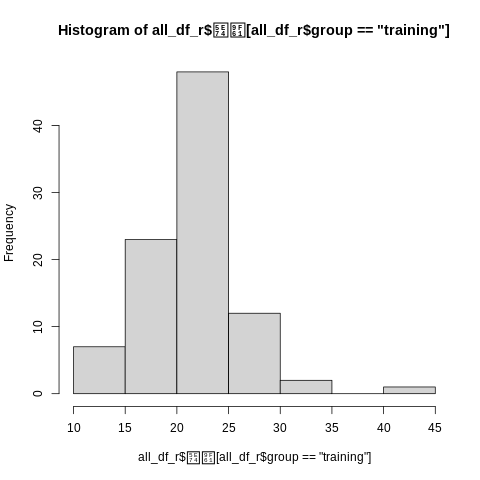

In [85]:
##8-0-4 Read Pands.DataFrame in R
%%R
all_df_r<-read.csv('all_df_r.csv')
hist(all_df_r$年齡[all_df_r$group=='training'])
##hist(all_df_r$年齡[all_df_r$group=='validating'])
##hist(all_df_r$年齡[all_df_r$group=='testing'])
formula<-'年齡~group'
ANOVA<-aov(all_df_r$網路成癮分數YDQ~all_df_r$groupNo)
ANOVA<-aov(all_df_r$家庭滿意度apgar~all_df_r$groupNo)
ANOVA<-aov(all_df_r$年齡~all_df_r$group)
summary(ANOVA)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


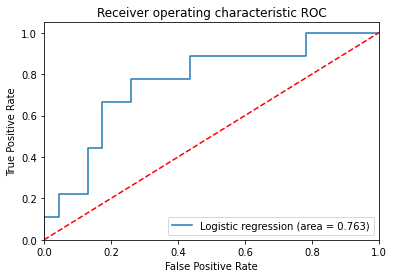

In [86]:
##8-0-5使用sklearn Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot as plt
model0=LogisticRegression()
result0=model0.fit(x_train,y_train)
預測機率0=result0.predict_proba(x_test)
AUC面積0=roc_auc_score(y_test,預測機率0[:,1])
fpr, tpr, thresholds = roc_curve(y_test,預測機率0[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic regression (area = %0.3f)' % AUC面積0)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic ROC')
plt.legend(loc="lower right")
plt.show()

In [87]:
##8-1-1 使用Tensorflow Logistic regression ...
import tensorflow as tf
from tensorflow.keras.layers import Dense 
from tensorflow.keras import Sequential
from tensorflow.keras.metrics import AUC, Precision, Recall
model1=Sequential()
model1.add(Dense(units=1,input_dim=4,activation='sigmoid')) ###'softmax' is for multiclass outcome.
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy',AUC(),Precision(),Recall()])
model1.fit(x_train, y_train, epochs=20,batch_size=10,validation_data=(x_vald,y_vald))

Epoch 1/20
10/10 [==============================] - 1s 56ms/step - loss: 11.4355 - accuracy: 0.1720 - auc_7: 0.5000 - precision_7: 0.1720 - recall_7: 1.0000 - val_loss: 10.3558 - val_accuracy: 0.1587 - val_auc_7: 0.5189 - val_precision_7: 0.1587 - val_recall_7: 1.0000
Epoch 2/20
10/10 [==============================] - 0s 7ms/step - loss: 11.1707 - accuracy: 0.1720 - auc_7: 0.5000 - precision_7: 0.1720 - recall_7: 1.0000 - val_loss: 10.0798 - val_accuracy: 0.1587 - val_auc_7: 0.5189 - val_precision_7: 0.1587 - val_recall_7: 1.0000
Epoch 3/20
10/10 [==============================] - 0s 4ms/step - loss: 10.9060 - accuracy: 0.1720 - auc_7: 0.5065 - precision_7: 0.1720 - recall_7: 1.0000 - val_loss: 9.8052 - val_accuracy: 0.1587 - val_auc_7: 0.5189 - val_precision_7: 0.1587 - val_recall_7: 1.0000
Epoch 4/20
10/10 [==============================] - 0s 4ms/step - loss: 10.6390 - accuracy: 0.1720 - auc_7: 0.5065 - precision_7: 0.1720 - recall_7: 1.0000 - val_loss: 9.5339 - val_accuracy: 0.158

In [88]:
##8-1-2 計算accuracy...
score1=model1.evaluate(x_test,y_test)
print('{}-->{}'.format(model1.metrics_names[0],score1[0]))
print('{}-->{}'.format(model1.metrics_names[1],score1[1]))
print('{}-->{}'.format(model1.metrics_names[2],score1[2]))
print('{}-->{}'.format(model1.metrics_names[3],score1[3]))
print('{}-->{}'.format(model1.metrics_names[4],score1[4]))

print('='*30)
from sklearn.metrics import roc_auc_score
print('AUC for testing set:')
predicted_prob=model1.predict(x_test)
roc_auc_score(y_test,predicted_prob)

1/1 [==============================] - 0s 440ms/step - loss: 4.8080 - accuracy: 0.2812 - auc_7: 0.6039 - precision_7: 0.2812 - recall_7: 1.0000
loss-->4.807977676391602
accuracy-->0.28125
auc_7-->0.6038647294044495
precision_7-->0.28125
recall_7-->1.0
AUC for testing set:


0.7657004830917874

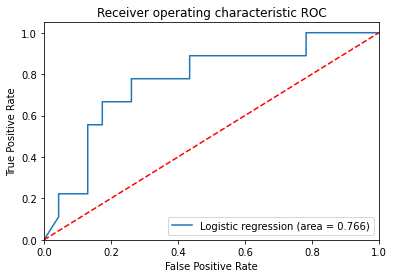

In [89]:
##8-1-3 繪製ROC曲線圖...
from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib import pyplot as plt
AUC面積=roc_auc_score(y_test, predicted_prob) ##0.6973180076628352
fpr,tpr,thresholds=roc_curve(y_test,predicted_prob)
plt.figure()
plt.plot(fpr,tpr,label='Logistic regression (area = %0.3f)'%AUC面積)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic ROC')
plt.legend(loc="lower right")
plt.show()

In [90]:
##8-2-1使用pytorch
import torch 
x_train_=torch.from_numpy(x_train.to_numpy().astype(np.float32))
x_vald_=torch.from_numpy(x_vald.to_numpy().astype(np.float32))
x_test_=torch.from_numpy(x_test.to_numpy().astype(np.float32))
y_train_=torch.from_numpy(y_train.to_numpy().astype(np.float32))
y_vald_=torch.from_numpy(y_vald.to_numpy().astype(np.float32))
y_test_=torch.from_numpy(y_test.to_numpy().astype(np.float32))

In [91]:
##8-2-2 建立 class
import torch
class Logistic_Reg_model(torch.nn.Module):
  def __init__(self,no_input_features):
    super(Logistic_Reg_model,self).__init__()
    self.layer1=torch.nn.Linear(no_input_features,4)
    self.layer2=torch.nn.Linear(4,1)
  def forward(self,x):
    y_predicted=self.layer1(x)
    y_predicted=torch.sigmoid(self.layer2(y_predicted))
    return y_predicted

In [92]:
##8-2-3 訓練model
import torch
樣本數,變項數=x_train_.shape
model2=Logistic_Reg_model(變項數)
criterion=torch.nn.BCELoss()
optimizer=torch.optim.SGD(model2.parameters(),lr=0.01)
number_of_epochs=20
for epoch in range(number_of_epochs):
  y_prediction=model2(x_train_)
  loss=criterion(y_prediction,y_train_)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  if (epoch+1)%10==0:
    print('epoch:',epoch+1,', loss=',loss.item())

epoch: 10 , loss= 0.48382654786109924
epoch: 20 , loss= 0.4760647416114807


In [93]:
##8-2-4測試testing group
import torch
with torch.no_grad():
  y_pred=model2(x_test_)
  y_pred_class=y_pred.round()
  accuracy=float(y_pred_class.eq(y_test_).sum())/float(y_test_.shape[0])
print(accuracy)
print(y_pred)

0.71875
tensor([[0.1372],
        [0.1420],
        [0.1797],
        [0.1182],
        [0.0873],
        [0.2477],
        [0.1246],
        [0.0829],
        [0.2579],
        [0.1605],
        [0.1673],
        [0.1736],
        [0.1407],
        [0.2862],
        [0.1775],
        [0.1628],
        [0.2158],
        [0.0943],
        [0.1115],
        [0.1633],
        [0.1168],
        [0.1938],
        [0.1083],
        [0.2894],
        [0.1372],
        [0.1935],
        [0.1864],
        [0.2332],
        [0.2227],
        [0.2938],
        [0.2180],
        [0.2906]])


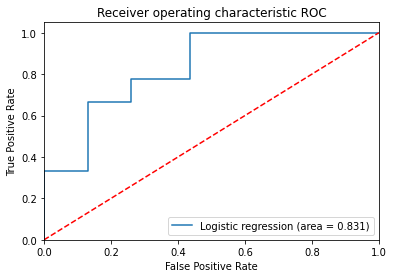

In [94]:
##8-2-5 計算AUC
from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib import pyplot as plt
AUC面積=roc_auc_score(y_test, y_pred) ##0.609
fpr,tpr,thresholds=roc_curve(y_test,y_pred)
plt.figure()
plt.plot(fpr,tpr,label='Logistic regression (area = %0.3f)'%AUC面積)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic ROC')
plt.legend(loc="lower right")
plt.show()

In [95]:
##8-3-1 Deep Learning Model...
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Dense 
model3=keras.Sequential()
model3.add(Dense(8,input_dim=4,activation='relu'))
model3.add(Dense(5,activation='relu'))
model3.add(Dense(1,activation='sigmoid'))
model3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 45        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 6         
Total params: 91
Trainable params: 91
Non-trainable params: 0
_________________________________________________________________


In [96]:
##8-3-2 Training model..
from tensorflow.keras.metrics import AUC, Precision, Recall
model3.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy',AUC(),Precision(),Recall()])
model3.fit(x_train, y_train,epochs=200, batch_size=10,validation_data=(x_vald,y_vald))

Epoch 1/200
10/10 [==============================] - 2s 123ms/step - loss: 0.7487 - accuracy: 0.4839 - auc_8: 0.6794 - precision_8: 0.2037 - recall_8: 0.6875 - val_loss: 0.5040 - val_accuracy: 0.7937 - val_auc_8: 0.6774 - val_precision_8: 0.3636 - val_recall_8: 0.4000
Epoch 2/200
10/10 [==============================] - 0s 6ms/step - loss: 0.5203 - accuracy: 0.8172 - auc_8: 0.6599 - precision_8: 0.4667 - recall_8: 0.4375 - val_loss: 0.4008 - val_accuracy: 0.8730 - val_auc_8: 0.6792 - val_precision_8: 0.6667 - val_recall_8: 0.4000
Epoch 3/200
10/10 [==============================] - 0s 4ms/step - loss: 0.4540 - accuracy: 0.8280 - auc_8: 0.6262 - precision_8: 0.5000 - recall_8: 0.2500 - val_loss: 0.3758 - val_accuracy: 0.8889 - val_auc_8: 0.6783 - val_precision_8: 0.8000 - val_recall_8: 0.4000
Epoch 4/200
10/10 [==============================] - 0s 6ms/step - loss: 0.4416 - accuracy: 0.8280 - auc_8: 0.6307 - precision_8: 0.5000 - recall_8: 0.1875 - val_loss: 0.3669 - val_accuracy: 0.8889

In [97]:
##8-3-3 計算accuracy...
score1=model3.evaluate(x_test,y_test)
print('{}-->{}'.format(model3.metrics_names[0],score1[0]))
print('{}-->{}'.format(model3.metrics_names[1],score1[1]))
print('{}-->{}'.format(model3.metrics_names[2],score1[2]))
print('{}-->{}'.format(model3.metrics_names[3],score1[3]))
print('{}-->{}'.format(model3.metrics_names[4],score1[4]))

print('='*30)
from sklearn.metrics import roc_auc_score
print('AUC for testing set:')
predicted_prob=model3.predict(x_test)
roc_auc_score(y_test,predicted_prob)

1/1 [==============================] - 0s 442ms/step - loss: 0.5371 - accuracy: 0.7812 - auc_8: 0.8043 - precision_8: 1.0000 - recall_8: 0.2222
loss-->0.5370879769325256
accuracy-->0.78125
auc_8-->0.8043478727340698
precision_8-->1.0
recall_8-->0.2222222238779068
AUC for testing set:


0.8067632850241545

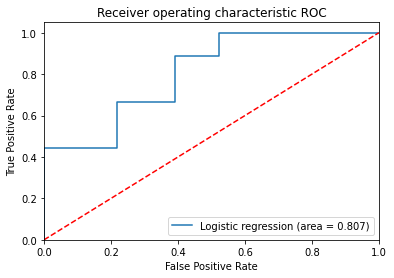

In [98]:
##8-3-4 計算AUC
from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib import pyplot as plt
AUC面積1=roc_auc_score(y_test, predicted_prob) ##0.609
fpr,tpr,thresholds=roc_curve(y_test,predicted_prob)
plt.figure()
plt.plot(fpr,tpr,label='Logistic regression (area = %0.3f)'%AUC面積1)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic ROC')
plt.legend(loc="lower right")
plt.show()

In [103]:
##8-4-1 save model
model3.save('./RPython/Model3',save_format='tf')

INFO:tensorflow:Assets written to: ./RPython/Model3/assets


In [127]:
##8-4-2
y_test[y_test['自殺意念01']==1]###找出y_test中自殺意念為1的index 
x_test.loc[186]        ##找出index=186的四個X值...

網路成癮分數YDQ      2.0
家庭滿意度apgar     0.0
年齡            21.0
sex_男          1.0
Name: 186, dtype: float64

In [128]:
##8-4-3 load & test model
model4=tf.keras.models.load_model('./RPython/Model3')
newCase={'網路成癮分數YDQ':[2],'家庭滿意度apgar':[0],'年齡':[21],'sex_男':[1]}
newCase=pd.DataFrame(newCase)
model4.predict(newCase)[0][0]


0.556754